# Building separate Ni2+/3+/4+ force fields

In [6]:
import matplotlib.pyplot as plt

from ase.io import read,write
from ase.build import bulk
import numpy as np
import ase.db as db
from ase.visualize import view
from ase.optimize import BFGS
Fit_on_forces=False

### Generate training data
Curvature Constrained Splines can be fitted to a reference data-set with energies (and optionally forces) of pre-calculated structures. In this example we generate the reference data-set using a Lennard-Jones potential. We use a LJ bulk structure that we randomly rattle and scale. 


for i in {1..19}; do (mkdir "outcar${i}"; mv "outcar${i}.txt" "outcar${i}/OUTCAR"); done
for i in {1..19}; do (echo "outcar/outcar${i}" >> data_list.txt); done
for f in $(ls OUTCARS/); do echo "OUTCARS/$f" >> data_list.txt; done

In [7]:
from ccs_fit.scripts.ccs_build_db import ccs_build_db

ccs_build_db(mode="CCS", DFT_DB="DFT.db", file_list="data_list.txt", overwrite=True, greedy=False) # false only takes last OUTCARs

    Building data-bases: 100%|███████████████████████████████████████████████████████████████████████████████████| 122/122 [00:15<00:00,  7.69it/s]


### Generate the CCS_fit input file; structures.json
The next commands fetch the training-set data from the ASE database containing the LJ structures and the corresponding energies. The reference data is called ``DFT_DB`` since the most common source of reference data is DFT.

In [4]:
# !ase db DFT.db

import ase
from ase import db

db_selection = db.connect("DFT_selection.db")
db_ref = db.connect("DFT.db")

for row in db_ref.select():
    if row.energy<-320:
        db_selection.write(row.toatoms())
        
!ase db DFT_selection.db

id|age|user   |formula|calculator|  energy|natoms|  fmax|pbc| volume|charge|    mass| smax
 1| 8s|tjams20|Ni18O36|vasp      |-323.985|    54| 7.129|TTT|603.577| 0.000|1632.445|0.062
 2| 8s|tjams20|Ni18O36|vasp      |-320.967|    54| 8.127|TTT|603.577| 0.000|1632.445|0.044
 3| 8s|tjams20|Ni18O36|vasp      |-323.830|    54| 5.253|TTT|603.577| 0.000|1632.445|0.078
 4| 8s|tjams20|Ni18O36|vasp      |-321.649|    54| 8.199|TTT|603.577| 0.000|1632.445|0.056
 5| 8s|tjams20|Ni18O36|vasp      |-326.494|    54| 5.622|TTT|603.577| 0.000|1632.445|0.078
 6| 8s|tjams20|Ni18O36|vasp      |-325.994|    54| 6.301|TTT|603.577| 0.000|1632.445|0.072
 7| 8s|tjams20|Ni18O36|vasp      |-329.366|    54| 3.871|TTT|603.577| 0.000|1632.445|0.079
 8| 8s|tjams20|Ni18O36|vasp      |-328.416|    54| 3.880|TTT|603.577| 0.000|1632.445|0.080
 9| 7s|tjams20|Ni18O36|vasp      |-321.260|    54|14.413|TTT|560.481| 0.000|1632.445|0.081
10| 7s|tjams20|Ni18O36|vasp      |-325.080|    54|10.728|TTT|560.481| 0.000|1632.445|0.053

In [8]:
from ccs_fit.scripts.ccs_fetch import ccs_fetch

ccs_fetch(mode="CCS",DFT_DB="DFT_selection.db", include_forces=Fit_on_forces)

    Fetching data: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:01<00:00, 21.07it/s]


### Fit training data to Curvature Constrained Splines
Finally, the splines are fitted to the target defined in the structures.json input file. The splines can be restricted to be fully repulsive ("rep"), or have a turning point/switch ("sw"), which is defined by the "Swtype" key.


In [9]:
### Generate input.json file
import json

input={
    "General": {
        "interface": "CCS",
        "merging"  : "True",
        "do_unconstrained_fit": "True"
    },
    "Twobody": {
                "Xx-Xx": {
                        "Rcut": 5.0,
                        "Resolution": 0.1,
                        "Swtype": "sw",
                        "const_type" : "Mono"
                },
                # "Ni-Ni": {
                #         "Rcut": 5.0,
                #         "Resolution": 0.1,
                #         "Swtype": "rep",
                #         "const_type" : "Mono"
                # },
                # "O-O": {
                #         "Rcut": 5.0,
                #         "Resolution": 0.1,
                #         "Swtype": "rep",
                #         "const_type" : "Mono"
                # }
        }
}
#SAVE TO FILE
with open('CCS_input.json', 'w') as f:
    json.dump(input, f, indent=8)

In [10]:
#RUN FIT
from ccs_fit import ccs_fit

ccs_fit("CCS_input.json")

    Generating one-body information from training-set.
        Added elements:  ['Ni', 'O']
    Generating two-body potentials from one-body information.
    Adding pair: Ni-Ni
    Adding pair: Ni-O
    Adding pair: O-O
    Applying monotonic constraints for pair:  Ni-Ni
    Applying monotonic constraints for pair:  Ni-O
    Applying monotonic constraints for pair:  O-O
    Merging intervals for pair Ni-Ni; number of intervals reduced from 27 to 17. 
    Merging intervals for pair Ni-O; number of intervals reduced from 37 to 31. 
    There is linear dependence in stochiometry matrix!
    Removing onebody term: O
    MSE of unconstrained problem is:  2.4380678566016085e-25
STRONG WARNING: THE EXPONENTIAL WALL IS ACTUALLY ATTRACTIVE!!!!!!!
STRONG WARNING: THE EXPONENTIAL WALL IS ACTUALLY ATTRACTIVE!!!!!!!
STRONG WARNING: THE EXPONENTIAL WALL IS ACTUALLY ATTRACTIVE!!!!!!!
    Merging intervals for pair Ni-Ni; number of intervals reduced from 27 to 17. 


/Users/tjams20/Documents/repos/CCS/src/ccs_fit/fitting/spline_functions.py:321: RuntimeWarning: invalid value encountered in log
  beta = alpha * r0 + np.log(cc / alpha**2)


    Merging intervals for pair Ni-O; number of intervals reduced from 37 to 31. 


    Finding optimum switch: 100%|███████████████████████████████████████████████████████████████████████████| 16337/16337 [02:00<00:00, 135.67it/s]

    The best switch is (19, 9, 15) with rmse: 0.04965380146574882, corresponding to distances of [4.33 2.36 3.57] Å for element pairs ['Ni-Ni', 'Ni-O', 'O-O'].


### Validate your potential
Make sure your potential (at least) reproduce the data points in your training-set. Performin further tests on strucutres not included in the training-set is recomended but not included in the tutorial.

In [13]:
from ccs_fit.scripts.ccs_validate import ccs_validate
ccs_validate(mode="CCS",CCS_params="CCS_params.json",DFT_DB="DFT_selection.db")

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:09<00:00,  2.30it/s]


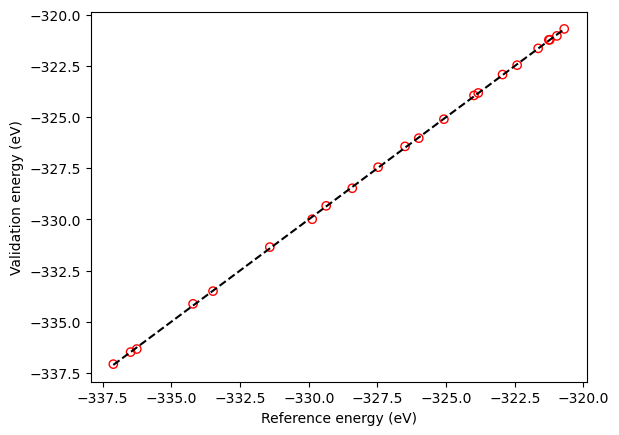

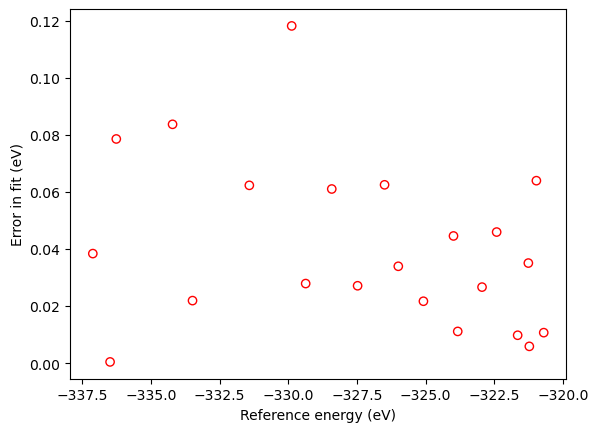

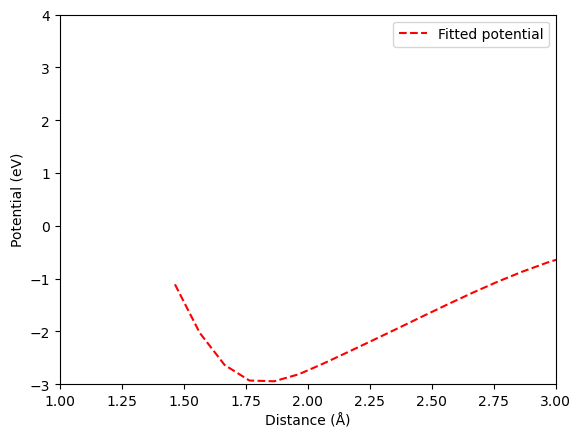

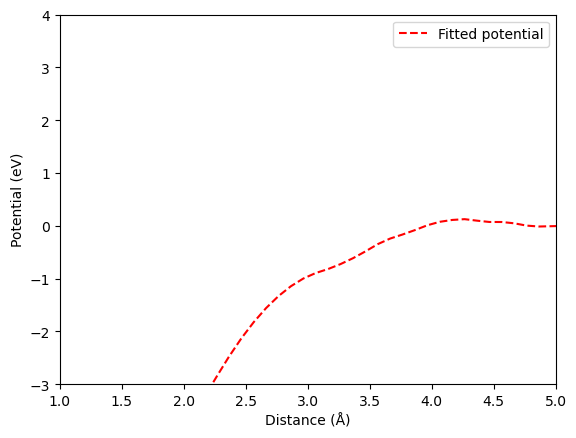

In [14]:
try:
    err=np.loadtxt("CCS_validate.dat")
    plt.xlabel('Reference energy (eV)')
    plt.ylabel('Validation energy (eV)')
    plt.plot( [min(err[:,0]),max(err[:,0])],[min(err[:,0]),max(err[:,0])],'--',color='black'  )
    plt.scatter(err[:,0],err[:,1],facecolors='none', edgecolors='red')
    plt.show()
    plt.xlabel('Reference energy (eV)')
    plt.ylabel('Error in fit (eV)')
    plt.scatter(err[:,0],err[:,2],facecolors='none', edgecolors='red')
    plt.show()
except:
    pass


with open("CCS_params.json", "r") as f:
    CCS_params = json.load(f)

r = np.array(CCS_params["Two_body"][f'Ni-O']["r"])
e=CCS_params["Two_body"][f'Ni-O']["spl_a"]

plt.xlim(1, 3)
plt.ylim(-3, 4)
plt.xlabel('Distance (Å)')
plt.ylabel('Potential (eV)')
plt.plot(r, e ,'--', color='red', label="Fitted potential")
plt.legend()
plt.show()

with open("UNC_params.json", "r") as f:
    UNC_params = json.load(f)

r = np.array(UNC_params["Two_body"][f'Ni-O']["r"])
e=UNC_params["Two_body"][f'Ni-O']["spl_a"]

plt.xlim(1, 5)
plt.ylim(-3, 4)
plt.xlabel('Distance (Å)')
plt.ylabel('Potential (eV)')
plt.plot(r, e ,'--', color='red', label="Fitted potential")
plt.legend()
plt.show()

Writing LAMMPS and GULP splines.


/usr/local/anaconda3/envs/Tantalizing/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/tjams20/Documents/repos/CCS/src/ccs_fit/scripts/ccs_export_FF.py:25: RuntimeWarning: overflow encountered in exp
  return De*((1-np.exp(-a*(r-re)))**2-1)


Buckingham fit (not optimised) for element pair Ni-Ni;     V(r) = 130.68*exp(-45.83*r) -(-3446.41)/r^6.
Lennard Jones fit (not optimised) for element pair Ni-Ni;  V(r) = 4*-11.18*((2.25/r)^12 - (2.25/r)^6)
Morse fit (not optimised) for element pair Ni-Ni;          V(r) = -11.46*((1-np.exp(-1.70*(r-2.39)))^2 - 1)
Pedone fit (not optimised) for element pair Ni-Ni;         V(r) = -4.12*((1-np.exp(-1.96*(r-3.09)))^2 - 1) + 1565723.54/r^12


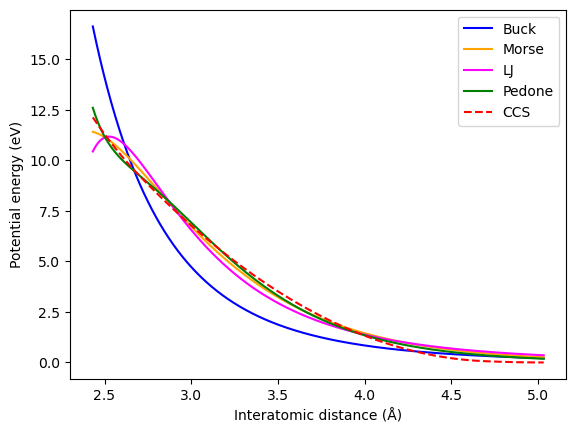

Buckingham fit (not optimised) for element pair Ni-O;     V(r) = -96.27*exp(-1.58*r) -(-87.83)/r^6.
Lennard Jones fit (not optimised) for element pair Ni-O;  V(r) = 4*3.76*((1.49/r)^12 - (1.49/r)^6)
Morse fit (not optimised) for element pair Ni-O;          V(r) = 2.98*((1-np.exp(-1.75*(r-1.82)))^2 - 1)
Pedone fit (not optimised) for element pair Ni-O;         V(r) = 2.85*((1-np.exp(-1.86*(r-1.89)))^2 - 1) + -237.71/r^12


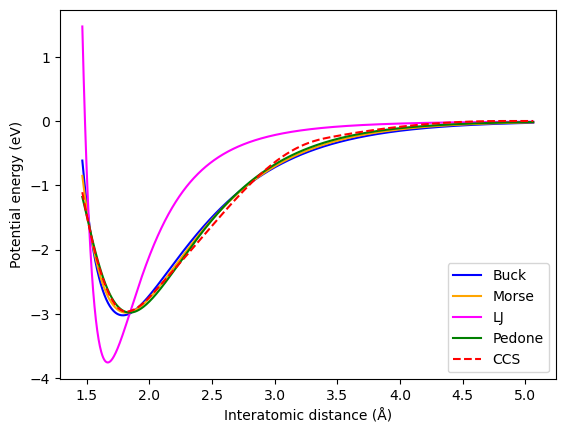

Buckingham fit (not optimised) for element pair O-O;     V(r) = -625.35*exp(-1.90*r) -(-894.07)/r^6.
Lennard Jones fit (not optimised) for element pair O-O;  V(r) = 4*2.03*((2.05/r)^12 - (2.05/r)^6)
Morse fit (not optimised) for element pair O-O;          V(r) = 1.87*((1-np.exp(-2.00*(r-2.34)))^2 - 1)
Pedone fit (not optimised) for element pair O-O;         V(r) = 0.95*((1-np.exp(-2.30*(r-2.73)))^2 - 1) + -74897.32/r^12


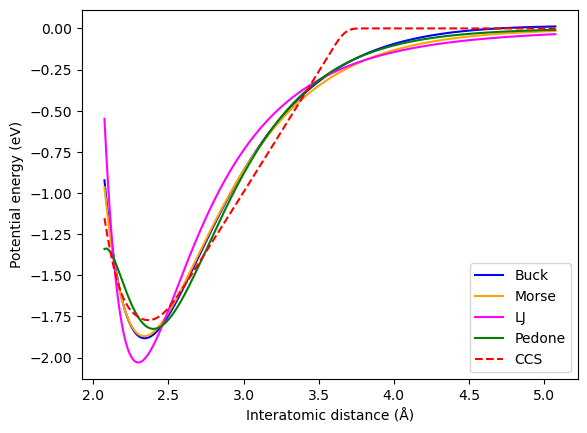

In [15]:
from ccs_fit.scripts.ccs_export_FF import write_FF
write_FF("CCS_params.json")

### Cleaning up

In [ ]:
from ase.io import read, write
from ase.constraints import StrainFilter
from ccs_fit.ase_calculator.ccs_ase_calculator import CCS
import json
from ase.optimize import BFGS

opt_struct = read('DFT.db@40')

with open ('CCS_params.json','r') as f:
    CCS_params=json.load(f)

CCS_calc = CCS(CCS_params=CCS_params, charge=True,q=charge_dict,charge_scaling=True)
    
opt_struct.calc = CCS_calc

print(opt_struct.get_stress())

orig_cell = opt_struct.cell.copy()

sf = StrainFilter(opt_struct)
opt = BFGS(sf, trajectory='CCS_strain.traj')
opt.run(fmax=1e-4)
alat = opt_struct.cell[0][1] - opt_struct.cell[0][0]

CCS_strain_opt = read('CCS_strain.traj')
CCS_strain_opt_cell = CCS_strain_opt.cell

old_vol = np.prod(np.diag(orig_cell))
new_vol = np.prod(np.diag(CCS_strain_opt_cell))

write("NiO2_opt_ccs.POSCAR", CCS_strain_opt)

print("Volume change of {} %, as a result of the following lattice parameter changes:".format((new_vol-old_vol)/old_vol*100))
print([np.diag(CCS_strain_opt_cell-orig_cell)[i]/np.diag(orig_cell)[i]*100 for i in range(3)])

print(np.diag(CCS_strain_opt_cell))

In [ ]:
struct = read('CCS_strain.traj')

CCS_calc = CCS(CCS_params=CCS_params)

struct.calc = CCS_calc

opt = BFGS(struct, trajectory='opt.traj')
opt.run(fmax=0.001)

In [ ]:
!ase gui CCS_strain.traj

In [ ]:
# Read geometry optimized structure and run NVE Molecular dynamics 
import numpy as np
from ase import units
from ase.io import read, write
from ase.io.trajectory import Trajectory
from ase.md import MDLogger
from ase.md.verlet import VelocityVerlet
from ase.md.velocitydistribution import (MaxwellBoltzmannDistribution,
                                         Stationary, ZeroRotation)

dt = 0.5 * units.fs
steps = int(300)
MaxwellBoltzmannDistribution(struct, temperature_K=600)
dyn = VelocityVerlet(struct, timestep=dt)
interval = int(1)
dyn.attach(MDLogger(dyn, struct, 'output.log', mode="a"), interval=interval)
dyn.attach(Trajectory('output.traj', 'a', struct).write, interval=interval)
dyn.run(steps)

In [ ]:
!ase gui output.traj